<h1> Generate Network Models

The code in this notebook generates and analyses fractal and non-fractal network models as described in [4].

**Module Imports**

In [1]:
# Network analysis modules
import networkx as nx
from igraph import Graph
import igraph

# Mathematics modules
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import powerlaw
from itertools import combinations

# Utility modules
import os
from operator import itemgetter

<h2> Tutorial

There are several network models available in this notebook, namely:
- Song-Havlin-Makse model
- Hub Attraction Dynamical Growth model
- $(u, v)$-flowers

<h3> Song-Havlin-Makse (SHM) Model

A SHM network relies on two predetermined parameters, $m$ and $p$, and is generated as follows

1. Begin with two nodes connected by a single edge. 

2. At stage $n$, $m$ offspring are connected to each endpoint of every node. 

3. Also at stage $n$, each edge in the $(n-1)$-th generation is removed randomly with independent probability $p$ and replaced with an edge between two of the new offspring at the endpoints of this edge.

This procedure is repeated $N$ times. 

To generate a Song-Havlin-Makse network use `generate_SHM_model`.

In [97]:
# Generate a SHM network with m=5, p=0.3, N=4.
SHM_G = generate_SHM_model(5, 0.3, 4)

Alternatively, we can generate SHM networks for a variety of values of $p$. 

In [117]:
# Generate SHM networks with m=3, N=5 and take 21 probabilities, so that p = 0.0, 0.05, 0.10, ..., 0.95, 1.0
SHM_graphs = generate_SHM_model_for_all_p(3, 5, prob_N=21)

Both of the above methods take the optional Boolean argument `save`, which when `True` saves the networks to a gml file.

To find the file path to a saved SHM network use the function `retrieve_SHM_model`.

In [122]:
generate_SHM_model(6, 0.1, 3, save=True)
retrieve_SHM_model(6, 0.1, 3, example=1)

(<networkx.classes.graph.Graph at 0x1cfedc53fd0>,
 'network-files/models/SHM-model/SHM-model-6-0.1-generation3-example1.gml')

The number of edges in a SHM network with parameters $m$ and $n$ is given by, 
\begin{equation}
 e(G_n) = (1+2m)^{n-1}.
\end{equation}

In [99]:
print(len(SHM_G.edges()))

1331


This can also be calculated using `SHM_no_of_edges`.

In [108]:
# Calculate the number of edges in a SHM network with m=5, N=4.
print(SHM_no_of_edges(5, 4))

1331


The number of nodes in a SHM network with parameters $m$ and $n$ is one more than the number of edges,
\begin{equation}
 v(G_n) = (1+2m)^{n-1} + 1.
\end{equation}

In [105]:
print(len(SHM_G.nodes()))

1332


This can also be calculated using `SHM_no_of_nodes`.

In [110]:
# Calculate the number of nodes in a SHM network with m=5, N=4.
print(SHM_no_of_nodes(5, 4))

1332


We can find deterministically the degree distribution of SHM networks for $p=0$ and $p=1$.

`SHM_p0_degree_prob(m, d, N)` finds the probability that a node has degree $d$ in a SHM network with parameters $m, N$ and $p=0$.
`SHM_p1_degree_prob(m, d, N)` does the same for $p=1$.

In a network with $p=0$, nodes can only have degree $(m+1)^k$ for some $k$.
In a network with $p=1$, nodes can only have degree $m^k$ or $2m^k$ for some $k$.

In [146]:
SHM_p0_degree_prob(2, 9, 7)

0.031997952131063614

In [148]:
SHM_p1_degree_prob(2, 9, 7)

0

In [150]:
SHM_p0_degree_prob(2, 4, 7)

0

In [152]:
SHM_p1_degree_prob(2, 4, 7)

0.09599385639319083

We can check that the calculated degree distribution is correct by comparing it to the true distribution of a generated network using `check_SHM_p0_degree_prob` and `check_SHM_p1_degree_prob`.

In [155]:
check_SHM_p0_degree_prob(2, 9, 7)

True

In [157]:
check_SHM_p1_degree_prob(2, 4, 7)

True

We can find the entire degree distribution with `SHM_p0_degree_dist(m, N)` and `SHM_p1_degree_dist(m, N)`.
The functions return a list of the degrees which appear in the network, and a list of their respective probabilities.

In [162]:
SHM_p0_degree_dist(4, 3)

([1, 5, 25], [0.8780487804878049, 0.0975609756097561, 0.024390243902439025])

In [166]:
SHM_p1_degree_dist(4, 3)

([1, 2, 4, 8, 16],
 [0.6585365853658537,
  0.21951219512195122,
  0.07317073170731707,
  0.024390243902439025,
  0.024390243902439025])

We can check the calculation with `check_SHM_p0_degree_dist(m, N)` and `check_SHM_p1_degree_dist(m, N)`.

In [171]:
check_SHM_p0_degree_dist(4, 3)

True

In [173]:
check_SHM_p1_degree_dist(4, 3)

True

This works for all values of $m$ and $N$.

In [176]:
correct = True
for N in [1,2,3,4,5]:
    for m in [2,3,4,5,6,7,8,9,10]:
        correct = correct and check_SHM_p0_degree_dist(m, N)
if correct:
    print("All distributions are correct!")

All distributions are correct!


In [178]:
correct = True
for N in [1,2,3,4,5]:
    for m in [2,3,4,5,6,7,8,9,10]:
        correct = correct and check_SHM_p1_degree_dist(m, N)
if correct:
    print("All distributions are correct!")

All distributions are correct!


SHM networks with parameters $p=0$ and $p=1$ are scale free, that is their degree distributions follow a power law of the form, 
\begin{equation} P(k) \approx k ^ {-\lambda} \end{equation}.
The value of $\lambda$ can be approximated by, 
\begin{equation}\lambda = \frac{\ln (1+2m)}{\ln (1+m)}, \end{equation} when $p=0$ and \begin{equation}\lambda = \frac{\ln (1+2m)}{\ln m}, \end{equation} when $p=1$.

We can compare the "true" value of $\lambda$ against the approximated value for $p=0$ using `check_SHM_p0_lambda'.

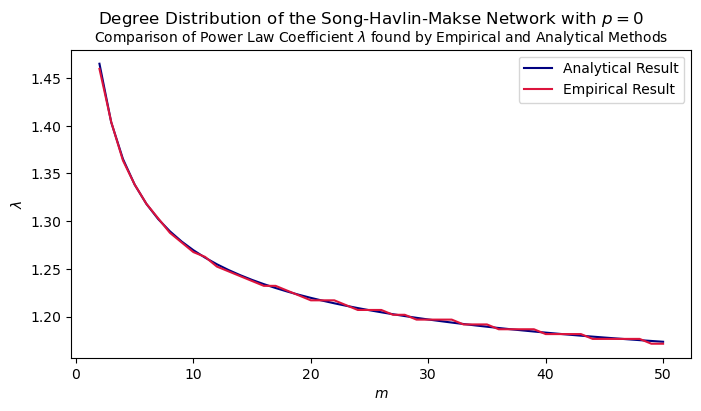

In [547]:
empirical, analytical = check_SHM_p0_lambda(10, 10, plot=True, verbose=False)

<h3> Hub Attraction Dynamical Growth (HADG) Model

The HADG model [3] is similar to the SHM model with some adaptations. It relies on predetermined parameters $a, b$ and $T$.

1. Begin with two nodes connected by a single edge. 

2. At stage $n$, $m$ offspring are connected to each endpoint of every node. 

3. Also at stage $n$, each edge $(u,v)$ in the $(n-1)$-th generation is removed randomly with independent probability
    \begin{align}
     p_{uv} = \begin{cases}
                 a, & \text{ if } \frac{d_{n-1}(u)}{d_{n-1}^\text{max}} > T \text{ and } \frac{d_{n-1}(v)}{d_{n-1}^\text{max}} > T, \\
                 b, & \text { otherwise.}
                 \end{cases}
    \end{align}
    where $d_{n-1}(x)$ is the degree of the node $x$ at time $n-1$ and $d_{n-1}^\text{max}$ is the maximum degree in the network at time $n-1$, and replaced with an edge between two of the new offspring at the endpoints of this edge.
    
4. At stage $n$, for each node $v$ in the $(n-1)$-th stage $d_{n-1}(v)$ edges are added between the new offspring of $v$.

This procedure is repeated $N$ times. 

To generate a HADG model use `generate_HADG_model`.

In [211]:
# Generates a HADG network with m=3, a=0.4, b=0.7, T=0.2 and N=5.
HADG_G = generate_HADG_model(3, 0.4, 0.7, 0.2, 5)

<h3> $(u,v)$-Flowers

A $(u, v)$-flower [1], with $1\le u<v$, is generated as follows:

1. Begin with a cycle graph of length $w= u+v$.

2. In the $n$-th generation, replace each edge in the graph from the $(n-1)$-th generation with two parallel paths, one of length $u$ and the other of length $v$.

The networks are fractal when $u >1$ and non-fractal when $u=1$.

In [218]:
# Generate a 5th generation (2,3)-flower
fractal_flower_G = generate_uv_flower(2, 3, 5)

In [220]:
# Generate a 5th generation (1,3)-flower
non_fractal_flower_G = generate_non_fractal_uv_flower(3, 5)

<h2> Workspace

**Fractal**

In [225]:
# Verified fractal networks

fractal_3_12_flower = Graph.Load("network-files/models/uv-flowers/3_12flower-generation3.gml")
fractal_2_6_flower = Graph.Load("network-files/models/uv-flowers/26flower-generation4.gml")
fractal_3_5_flower = Graph.Load("network-files/models/uv-flowers/35flower-generation4.gml")
fractal_4_10_flower = Graph.Load("network-files/models/uv-flowers/410flower-generation3.gml")
fractal_6_9_flower = Graph.Load("network-files/models/uv-flowers/6_9flower-generation3.gml")

fractal_SHM_2_6 = Graph.Load("network-files/models/SHM-model/SHM-model-2-0.8-generation6-example1.gml")
fractal_SHM_3_5 = Graph.Load("network-files/models/SHM-model/SHM-model-3-0.8-generation5-example1.gml")
fractal_SHM_7_4 = Graph.Load("network-files/models/SHM-model/SHM-model-7-0.8-generation4-example1.gml")
fractal_SHM_27_3 = Graph.Load("network-files/models/SHM-model/SHM-model-27-0.8-generation3-example1.gml")
fractal_SHM_28_3 = Graph.Load("network-files/models/SHM-model/SHM-model-28-0.8-generation3-example1.gml")

fractal_graphs_3000 = [fractal_3_12_flower, fractal_2_6_flower, fractal_3_5_flower, fractal_4_10_flower, fractal_6_9_flower, 
                       fractal_SHM_2_6, fractal_SHM_3_5, fractal_SHM_7_4, fractal_SHM_27_3]
save_paths = ["3_12flower-generation3", "26flower-generation4", "35flower-generation4", "410flower-generation3", "6_9flower-generation",
              "SHM-model-2-0.8-generation6-example1", "SHM-model-3-0.8-generation5-example1", "SHM-model-7-0.8-generation4-example1", "SHM-model-27-0.8-generation3-example1", "SHM-model-28-0.8-generation3-example1"]

**Non-Fractal**

In [222]:
# Verified non-fractal networks

non_fractal_1_2_flower = Graph.Load("network-files/models/uv-flowers/12flower-generation8.gml")
non_fractal_1_3_flower = Graph.Load("network-files/models/uv-flowers/13flower-generation6.gml")
non_fractal_1_13_flower = Graph.Load("network-files/models/uv-flowers/14flower-generation5.gml")
non_fractal_1_7_flower = Graph.Load("network-files/models/uv-flowers/17flower-generation4.gml")
non_fractal_1_14_flower = Graph.Load("network-files/models/uv-flowers/1_14flower-generation3.gml")

non_fractal_SHM_2_6 = Graph.Load("network-files/models/SHM-model/SHM-model-2-0.2-generation6-example1.gml")
non_fractal_SHM_3_5 = Graph.Load("network-files/models/SHM-model/SHM-model-3-0.2-generation5-example1.gml")
non_fractal_SHM_7_4 = Graph.Load("network-files/models/SHM-model/SHM-model-7-0.2-generation4-example3.gml")
non_fractal_SHM_27_3 = Graph.Load("network-files/models/SHM-model/SHM-model-27-0.2-generation3-example1.gml")
non_fractal_SHM_28_3 = Graph.Load("network-files/models/SHM-model/SHM-model-28-0.2-generation3-example1.gml")

non_fractal_graphs_3000 = [non_fractal_1_2_flower, non_fractal_1_3_flower, non_fractal_1_13_flower, non_fractal_1_7_flower, non_fractal_1_14_flower,
                          non_fractal_SHM_2_6, non_fractal_SHM_3_5, non_fractal_SHM_7_4, non_fractal_SHM_27_3, non_fractal_SHM_28_3]

<h1>Functions

<h2> 1. Fractal Models

<h3> 1.1 Song-Havlin-Makse (SHM) Model

A SHM network relies on two predetermined parameters, $m$ and $p$, and is generated as follows

1. Begin with two nodes connected by a single edge. 

2. At stage $n$, $m$ offspring are connected to each endpoint of every node. 

3. Also at stage $n$, each edge in the $(n-1)$-th generation is removed randomly with independent probability $p$ and replaced with an edge between two of the new offspring at the endpoints of this edge.

This procedure is repeated $N$ times. 

**Generate a SHM network with parameters $(m, p, N)$**

In [3]:
def generate_SHM_model(m, p, N, save=False):
    """
    Generates an n-th generation SHM network with parameters m and p.
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [2].
        p (float): The probability of rewiring an edge, as defined by the SHM model [2]. 
        N (int): The number of iterations to perform of the SHM generative process [2].
        save (bool) (opt): If True, the file is saved to the network-files folder. Default is False.
        
    Returns:
        G (networkx.Graph): The generated SHM network.
    """
    
    # In the first generation the network is a path of length 2. 
    G = nx.path_graph(2)
    
    # Generate the next generation N times. 
    for i in range(N-1):
        G = SHM_iteration(G, m, p)
        
    # Save the file is save is True.
    if save==True:
        # Save the file in the format SHM-model-m-p-generationN-examplei.gml
        # For p != 0 the method is non-deterministic and so multiple examples need to be saved. 
        count = 1
        # Initialise a Boolean variable to False, where False means that it is yet to be saved, and True means it has been saved. 
        saved = False
        
        # Iterate while the file is yet to be saved. 
        while saved == False:
            filename = "SHM-model-" + str(m) + "-" + str(p) + "-generation" + str(N) + "-example" + str(count) + ".gml"
            filepath = "network-files/models/SHM-model/" + filename
            # If the count-th example already exists, increment the count by 1 and try to save again.
            if not os.path.isfile(filepath):
                nx.write_gml(G, filepath)
                saved=True
            else:
                count += 1
    
    # Return the generated graph
    return G

In [4]:
def SHM_iteration(G, m, p):
    """
    Performs one iteration of the generative process for the SHM model.
    
    Args:
        G (networkx.Graph): The network from the previous generation.
        m (int): The number of offspring added at each stage, as defined by the SHM model [2].
        p (float): The probability of rewiring an edge, as defined by the SHM model [2]. 
        
    Returns:
        G (networkx.Graph): The network in the new generation.
    """
    # Find a list of all existing edges in the network.
    edges = list(G.edges())
    
    # For each edge, add m offspring to each endpoint of the edge.
    for edge in edges:
        G, source_offspring = add_m_offspring(G, edge[0], m)
        G, target_offspring = add_m_offspring(G, edge[1], m)
        
        # With probability p, rewire the original edge.
        if random.random() <= p:
            rewire_offspring(G, edge, source_offspring, target_offspring)
        
    # Return the updated network.
    return G

In [7]:
def add_m_offspring(G, node, m):
    """
    Adds m offspring to a given node, connected by a single edge.
    
    Args:
        G (networkx.Graph): The network in its current state.
        node (int): The node to which the offspring are to be added. 
        m (int): The number of offspring.
        
    Returns:
        G (networkx.Graph): The updated network.
        new_nodes (list): A list of the names of all the new nodes added at the previous stage.
    """
    # Find the number of nodes in the network
    N = len(G.nodes())
    
    # Add new nodes, named for the next available i integers.
    new_nodes = [N+i for i in range(m)]
    # Create a list of new edges, one connecting each new node to the original node.
    new_edges = zip(new_nodes, [node]*m)
    
    # Add the new edges and vertices
    G.add_nodes_from(new_nodes)
    G.add_edges_from(new_edges)
    
    # Return the updated graph, and a list of the new nodes.
    return G, new_nodes
    

In [9]:
def rewire_offspring(G, edge, source_offspring, target_offspring):
    """
    Rewires a given edge, replacing it with an edge between two randomly chosen offspring of the current endpoints [2].
    
    Args:
        G (networkx.Graph): The network in its current state.
        edge (tuple): The edge to be rewired.
        source_offspring (list): A list of offspring of the source node.
        target_offspring (list): A list of offspring of the target node.
        
    Returns:
        G (networkx.Graph): The updated network.        
    """
    # Remove the original edge.
    G.remove_edge(edge[0], edge[1])
    
    # Choose a new source at random from the original source node's offspring.
    new_source = random.choice(source_offspring)
    # Choose a new target at random from the original target node's offspring.
    new_target = random.choice(target_offspring)
    
    # Add a new edge between the new source and target.
    G.add_edge(new_source, new_target)
    
    # Return the updated network.
    return G

**Generating SHM Networks for Multiple Probabilities**

Sometimes it is useful to generate SHM networks with the same parameters $m$ and $N$, but with different rewiring probabilities $p$. This is particularly true since $p$ determines the network's fractality. 

In [12]:
def generate_SHM_model_for_all_p(m, N, prob_N=11, example_N=1, save=False):
    """
    Generate SHM networks for a fixed m and N, for multiple values of p. 
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [2].
        N (int): The number of iterations to perform of the SHM generative process [2].
        prob_N (int): The number of probabilities to generate the graph for. Default is 11, so will generate networks with p in [0.0, 0.1, 0.2, ..., 0.9, 1.0]
        example (int) (opt): The number of networks of each probability to generate. Default is 1. 
        save (Bool) (opt): If True, save each of the networks to a .gml file. Default is False.
    
    Returns:
        probabilities (numpy.ndarray): A list of the probabilities which are used.
        graphs (list): A list of lists of generated networks. The sublist graphs[i] contains graphs with p=probabilities[i].
    """
    # Generate the list of probabilities p.
    probabilities = np.linspace(0, 1, prob_N)
    
    # Initialise an empty list to store networks.
    graphs = []
    
    # Iterate for each probability.
    for p in probabilities:
        # Initialise an empty list to store networks with probability p.
        p_graphs = []
        # Generate such a network and add it to the list.
        for i in range(example_N):
            G = generate_SHM_model(m, p, N, save=save)
            p_graphs.append(G)
        # Add the list of networks with probability p to the overall list.
        graphs.append(p_graphs)
    
    # Return a list of probabilities and graphs.
    return probabilities, graphs

**Finding a Saved SHM Network File**

In [15]:
def retrieve_SHM_model(m, p, N, example=1):
    """
    Given the parameters m, p, N and the example number, retrieve the file containing the SHM network. 
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [2].
        p (float): The probability of rewiring an edge, as defined by the SHM model [2]. 
        N (int): The number of iterations to perform of the SHM generative process [2].
        example (int) (opt): In the case of multiple graphs with the same parameters, specifies the example wanted. Default is 1.
        
    Returns:
        G (networkx.Graph): The saved SHM network with the above specified parameters. 
        filepath + filename (str): The filepath to the network file.
    """
    
    # Find the filepath to the model with these parameters. 
    filename = "SHM-model-" + str(m) + "-" + str(p) + "-generation" + str(N) + "-example" + str(example) + ".gml"
    filepath = "network-files/models/SHM-model/"

    # Read the network.
    G = nx.read_gml(filepath+filename)
    
    # Return the networkx graph.
    return G, filepath+filename

<h3> 1.2 Hub Attractraction Dynamical Growth (HADG) Model

The HADG model [3] is similar to the SHM model with some adaptations. It relies on predetermined parameters $a, b$ and $T$.

1. Begin with two nodes connected by a single edge. 

2. At stage $n$, $m$ offspring are connected to each endpoint of every node. 

3. Also at stage $n$, each edge $(u,v)$ in the $(n-1)$-th generation is removed randomly with independent probability
    \begin{align}
     p_{uv} = \begin{cases}
                 a, & \text{ if } \frac{d_{n-1}(u)}{d_{n-1}^\text{max}} > T \text{ and } \frac{d_{n-1}(v)}{d_{n-1}^\text{max}} > T, \\
                 b, & \text { otherwise.}
                 \end{cases}
    \end{align}
    where $d_{n-1}(x)$ is the degree of the node $x$ at time $n-1$ and $d_{n-1}^\text{max}$ is the maximum degree in the network at time $n-1$, and replaced with an edge between two of the new offspring at the endpoints of this edge.
    
4. At stage $n$, for each node $v$ in the $(n-1)$-th stage $d_{n-1}(v)$ edges are added between the new offspring of $v$.

This procedure is repeated $N$ times. 

In [19]:
def generate_HADG_model(m, a, b, T, N, save=False):
    """
    Generates an Nth generation HADG network with parameters m, a, b and T [5][3].
    
    Args:
        m (int): The number of offspring added at each stage, as according to [5].
        a (float): The probability of rewiring an edge if node degree is over the threshold [5].
        b (float): The probability of rewiring an edge otherwise [5].
        T (float): The threshold as according to [5].
        N (int): The number of iterations to perform of the HADG generative process.
        save (Bool) (opt): If True, saved the resulting network to a gml file. Default is False.
        
    Returns:
        G (networkx.Graph): The resulting HADG network.
    """
    # In the first generation the network is a path of length 2. 
    G = nx.path_graph(2)
    
    # Apply the generative process N times. 
    for i in range(N-1):
        G = HADG_iteration(G, m, a, b, T)
        
    # Save the file is save is True.
    if save==True:
        # Save the file in the format HADG-model-m-p-generationN-examplei.gml
        # The method is non-deterministic and so multiple examples need to be saved. 
        count = 1
        # Initialise a Boolean variable to False, where False means that it is yet to be saved, and True means it has been saved. 
        saved = False
        
        # Iterate while the file is yet to be saved.
        while saved == False:
            filename = "HADG-model-" + str(m) + "-" + str(p) + "-generation" + str(N) + "-example" + str(count) + ".gml"
            filepath = "network-files/models/HADG-model/" + filename
            # If the count-th example already exists, increment the count by 1 and try to save again.
            if not os.path.isfile(filepath):
                nx.write_gml(G, filepath)
                saved=True
            else:
                count += 1
    
    # Return the generated graph.
    return G

In [207]:
def HADG_iteration(G, m, a, b, T):
    """
    Performs one iteration of the HADG generative process [5][3]. 
    
    Args:
        G (networkx.Graph): The network in its current state. 
        m (int): The number of offspring added at each stage, as according to [5].
        a (float): The probability of rewiring an edge if node degree is over the threshold [5].
        b (float): The probability of rewiring an edge otherwise [5].
        T (float): The threshold as according to [5].
        
    Returns:
        G (networkx.Graph): The updated network.
    """
    # Initialise a dictionary where each node is a key and each value starts as an empty list. 
    # This dictionary will store a list of the newly added nodes to which a previously existing node is adjacent.
    new_node_dict = dict.fromkeys(list(G.nodes()), [])
    
    # Find a list of the edges in the previous generation.
    edges = list(G.edges())
    # Find a list of the node degrees in the previous generation.
    degrees = G.degree
    
    # Iterate through each of the edges in the previous generation. 
    for edge in edges:
        # Add m offspring to the source node of the edge.
        G, source_offspring = add_m_offspring(G, edge[0], m)
        # Add m offspring to the target node of the edge.
        G, target_offspring = add_m_offspring(G, edge[1], m)
        
        # Find the degree of the source node in the previous generation.
        degx = degrees[edge[0]]
        # Find the degree of the target node in the previous generation.
        degy = degrees[edge[1]]
        # Find the maximum degree in the previous generation.
        degmax = max([deg[1] for deg in degrees])
        
        # If the degree of both the source and target node, relative to the maximum degree, are over the threshold then
        #    rewire the edge with probability a.
        if degx/degmax > T and degy/degmax >T:
            if random.random() <= a:
                rewire_offspring(G, edge, source_offspring, target_offspring)
        # Otherwise rewire the edge with probability b.
        else:
            if random.random() <= b:
                rewire_offspring(G, edge, source_offspring, target_offspring)
                
        # Update the dictionary of new neighbours for the source node. 
        source_neighbours = new_node_dict[edge[0]].copy()
        source_neighbours.extend(source_offspring)
        new_node_dict[edge[0]] = source_neighbours
        
        # Update the dictionary of new neighbours for the target node.
        target_neighbours = new_node_dict[edge[1]].copy()
        target_neighbours.extend(target_offspring)
        new_node_dict[edge[1]] = target_neighbours
        
    # Iterate through each of the nodes from the previous generation.
    for node in new_node_dict:
        # Find the list of new neighbours for that node.
        neighbours = new_node_dict[node]
        # Find the degree of the node at the previous generation.
        deg = degrees[node]
        
        # Find all possible pairs of new neighbours, i.e. all possible edges between the new offspring of the node.
        possible_edges = [i for i in combinations(neighbours, 2)]
        
        # Choose d random new edges where d is the degree of the node at the previous stage.
        new_edges = random.sample(possible_edges, min(deg, len(possible_edges)))
        # Add these new edges to the network.
        G.add_edges_from(new_edges)
        
    # Return the updated network.
    return G

<h3> 1.3 $(u, v)$-Flowers

A $(u, v)$-flower [1], with $1<u<v$, is generated as follows:

1. Begin with a cycle graph of length $w= u+v$.

2. In the $n$-th generation, replace each edge in the graph from the $(n-1)$-th generation with two parallel paths, one of length $u$ and the other of length $v$.

This network is self similar because the $n$-th generation contains $w$ copies of the $(n-1)$-th generation.

The model is also deterministic.

In [25]:
def generate_uv_flower(u, v, N):
    """
    Generates an n-th generation (u,v)-flower.
    
    Args:
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        N (int): Number of generations.
        
    Returns:
        filepath (str): File path to .gml file containing generated network.
    """
    # Initialise a cycle graph of length w = u + v
    G = nx.cycle_graph(u+v)
    
    # For each of the n generations, perform one iteration of the generative process. 
    for i in range(N-1):
        G = uv_iteration(G, u, v)
        
    # Save the file in the format uvflower-generationN.gml
    filename = str(u) + "_" + str(v) + "flower-generation" + str(N) + ".gml"
    filepath = "network-files/models/uv-flowers/" + filename
    nx.write_gml(G, filepath)
    
    return filepath

In [27]:
def uv_iteration(G, u, v):
    """
    Performs one iteration in the (u,v)-flower generation process. 
    
    Args:
        G (networkx.Graph): The (u,v)-flower network in its current (t-1)-th generation. 
        u (int): Value of u, i.e. path length of one of the parallel paths. 
        v (int): Value of v, i.e. path length of one of the parallel paths. 
        
    Returns:
        G (networkx.Graph): The (u,v)-flower network in the t-th generation. 
        
    """
    # Find a list of all the nodes and edges in the network at the (t-1)-th generation.
    nodes = list(G.nodes())
    edges = list(G.edges())
    
    # Remove all the existing edges. 
    G.remove_edges_from(G.edges())

    # Iterate through each of the edges from the network in the (t-1)-th generation.
    for edge in edges:
        # n is used to store the smallest integer which isn't yet a node label. 
        # The nodes are labelled 0, ..., n-1, so this is n.
        n = len(G.nodes())
        
        # Replace the edge with a path of length u.
        # First find a path graph using these vertices.
        Hu, n = add_new_path(u, n, edge)
        # Then merge this path graph with the existing network.
        G = nx.compose(G, Hu)
        
        # Replace the edge with a path of length v.
        # First find a path graph using these vertices.
        Hv, n = add_new_path(v, n, edge)
        # Then merge this path graph with the existing network.
        G = nx.compose(G, Hv)

    # Return the graph after all iterations. 
    return G

In [29]:
def add_new_path(l, n, edge):
    """
    Adds a new parallel path to the network, a step in the (u, v)-flower generation process. 
    
    Args:
        l (int): The length of the path to be added to the network.
        n (int): A counter which stores the next unused integer to label nodes. 
        edge (tuple): The edge from the network being replaced with parallel paths. 
        
    Returns:
        Hl (networkx.Graph): A path graph of length l with vertices labelled correctly. 
        n (int): A counter which stores the next unused integer to label nodes. 
    """
    # Generate a path graph with l edges (and l+1 vertices). 
    Hl = nx.path_graph(l+1)
    
    # Create an empty dictionary to be used to relabel the nodes in the path. 
    l_rlbl = {key:None for key in list(Hl.nodes)}
    
    # The nodes in the path graph are labelled from 0 to l. 
    # Thus, the node 0 in this path corresponds to the source node of the original edge,
    #   and the node l in this path corresponds to the target node of the original edge.
    
    # Iterate through all the nodes in the path.
    for node in list(Hl.nodes()):
        # If the node is 0 in the path, relabel it as the source of the original edge.
        if node == 0:
            l_rlbl[node] = edge[0]
        # If the node is l in the path, relabel it as the source of the original edge.
        elif node == l:
            l_rlbl[node] = edge[1]
        # For all other nodes, relabel it as the next unused integer. 
        else:
            l_rlbl[node] = n
            # Increment the counter n, so that n is now the next unused integer. 
            n += 1
            
    # Relabel the nodes according to the scheme described above. 
    Hl = nx.relabel_nodes(Hl, l_rlbl)
    
    # Return the path graph to be merged with the (u, v)-flower graph, and the counter for the next unused integer for node labels. 
    return Hl, n

<h2> 2. Non-Fractal Models

<h3> 2.1 $(u, v)$-Flowers

It was shown in [1] that $(u, v)$-flowers with $u=1$ are non-fractal. 

In [34]:
def generate_non_fractal_uv_flower(v, N):
    """
    Generates a non-fractal (u,v)-flower with u=1.
    
    Args:
        v (int): Value of v, i.e. path length of the parallel paths. 
        N (int): Number of generations.
        
    Returns:
        filepath (str): File path to .gml file containing generated network.
    """
    # Returns the (u,v)-flower found by the fractal generator, but with u hardcoded as 1. 
    return generate_uv_flower(1, v, N)

<h1> 3 Verifying Properties

<h2> 3.1 SHM Model

**General Properties**

The number of edges in a SHM network with parameters $m$ and $n$ is given by, 
\begin{equation}
 e(G_n) = (1+2m)^{n-1}.
\end{equation}

In [40]:
def SHM_no_of_edges(m, n):
    """
    Finds the number of edges in an n-th generation SHM network with parameter m.
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [2].
        N (int): The number of iterations to perform of the SHM generative process [2].
        
    Returns:
        (int): The number of edges in the network.
    """
    # A SHM network has (1+2m)^(n-1) edges.
    return (1+2*m)**(n-1)

The number of vertices is one more than the number of edges:
\begin{equation}
 v(G_n) = (1+2m)^{n-1} + 1.
\end{equation}

In [43]:
def SHM_no_of_nodes(m, N):
    """
    Finds the number of nodes in an n-th generation SHM network with parameter m.
    
    Args:
        m (int): The number of offspring added at each stage, as defined by the SHM model [2].
        N (int): The number of iterations to perform of the SHM generative process [2].
        
    Returns:
        (int): The number of nodes in the network.
    """
    # A SHM network has (1+2m)^(n-1)+1 nodes.
    return (1+2*m)**(N-1) + 1

**Degree Distribution for $p=0$**

The following code calculates, according to the analytical arguments of [4], the probability $P(d)$ for a degree $d$ in the probability distribution of a SHM network with parameters $m$, $N$ and $p=0$.

In [47]:
def SHM_p0_degree_prob(m, d, N):
    """
    Calculates the probability P(d) for a given degree d in a SHM network with parameters m, N and p=0.
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        d (int): The degree to find the probability density P(d) for.
        N (int): The parameter N in the SHM network model [2]
        
    Returns:
        (float): The probability P(d) from the degree distribution.
    """
    # The maximum degree in a network with parameters m, N is (1+m)^(N-1) [4].
    # Thus for any larger degree d, the probability of a node having degree d is 0.
    if d > (1+m) ** (N-1):
        return 0
    
    # All degrees in a SHM network with p=0 are powers of (1+m)
    power, is_power = exact_log(d, (1+m)) # Check if d is a power of (1+m) and find the exponent.
    
    # If d is a power, then we can find P(d).
    if is_power:
        # Nodes added at stage k have degree d = (1+m)^power = (1+m)^(N-k), so k = N-power.
        k = N - power
        
        # In the first stage, 2 nodes are added.
        if k == 1:
            no_deg_d = 2
            
        # In every subsequent stage (1+2m)^(k-1) - (1+2m)^(k-2) nodes are added.
        else:
            no_deg_d = (1+2*m)**(k-1) - (1+2*m)**(k-2)
        
        # Find the total number of nodes in the network.
        total = SHM_no_of_nodes(m, N)
        
        # The probability that a node has degree d is the number of nodes with degree d divided by the total number of nodes.
        return no_deg_d/total

    # For all other degrees, return 0.
    else:
        return 0

The accuracy of the above function can be checked with the following function. It generates a SHM network and checks that the true probability $P(d)$ for degree $d$ is the same as the one calculated by `SHM_p1_degree_prob`.

In [50]:
def check_SHM_p0_degree_prob(m, d, N):
    """
    Checks the accuracy of the calculated degree probability, according to analytical arguments in [4].
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        d (int): The degree to find the probability density P(d) for.
        N (int): The parameter N in the SHM network model [2]
        
    Returns:
        (Bool): True if the two values agree, and False if they disagree. 
    """
    # Generate a SHM network with parameters m, N, p=0.
    G = generate_SHM_model(m, 0, N, save=False)
    
    # Find a list of the degrees in the network.
    degrees = [deg[1] for deg in G.degree()]
    
    # Count the number of nodes with degree d.
    no_deg_d = degrees.count(d)
    # The probability that a node has degree d is the number of nodes with degree d divided by the total number of nodes.
    prob = no_deg_d/len(degrees)
    
    # Find the calculated probability according to the analytical arguments. 
    est_prob = SHM_p0_degree_prob(m, d, N)
    
    # Return True if the values agree, and False if not.
    return prob == est_prob

To calculate the entire degree distribution we need to calculate $P(d)$ for all possible $d$.

In [53]:
def SHM_p0_degree_dist(m, N):
    """
    Calculates the degree distribution of a SHM network with p=0
    
    Args:
        m (int): The parameter m in the SHM network model to test [2]
        N (int): The parameter N in the SHM network model [2]
        
    Returns: 
        degrees (list): A list of the degrees in the network.
        degree_dist (list): A list of probabilities of a node having a given degree. 
    """
    # Initialise empty lists for the degrees and the degree distribution
    degrees = []
    degree_dist = []
    
    # Iterate through each of the generative stages 1, 2, ..., N
    for k in range(N, 0, -1):
        # The degree of a node added at time k is (1+m)^(N-k)
        d = (1+m) ** (N-k)
        # Add the degree d to the list of degrees.
        degrees.append(d)
        # Add the probability P(d) to the degree distribution.
        degree_dist.append(SHM_p0_degree_prob(m, d, N))
        
    # Return the list of degrees and the degree distribution.
    return degrees, degree_dist

The accuracy of `SHM_p0_degree_dist` is checked using `check_SHM_p0_degree_dist`.

In [56]:
def check_SHM_p0_degree_dist(m, N):
    """
    Checks the accuracy of the calculated degree distribution, according to analytical arguments in [4].
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        N (int): The parameter N in the SHM network model [2]
        
    Returns:
        (Bool): True if the two distributions agree, and False if they disagree. 
    """
    # Generate a SHM network with parameters m, N, p=0.
    G = generate_SHM_model(m, 0, N, save=False)
    # Find the degree distribution.
    degrees = [deg[1] for deg in G.degree()]
    
    # Find a sorted list of degrees without repetition.
    unique_degrees = list(set(degrees))
    unique_degrees.sort()
    
    # Initialise an empty list for the degree distribution.
    degree_dist = []
    
    # For each of the degrees, find the number of occurrences and divide that by the total number of nodes.
    for d in unique_degrees:
        no_deg_d = degrees.count(d)
        prob = no_deg_d/len(degrees)
        # Add the probability to the degree distribution
        degree_dist.append(prob)
    
    # Find the estimated degree distribution according to the analytical arguments. 
    _, est_degree_dist = SHM_p0_degree_dist(m, N)
    
    # Return True if the distributions are the same, and False otherwise. 
    return degree_dist == est_degree_dist

**Degree Distribution for $p=1$**

The following code calculates, according to the analytical arguments of [4], the probability $P(d)$ for a degree $d$ in the probability distribution of a SHM network with parameters $m$, $N$ and $p=1$.

In [60]:
def SHM_p1_degree_prob(m, d, N):
    """
    Calculates the probability P(d) for a given degree d in a SHM network with parameters m, N and p=1.
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        d (int): The degree to find the probability density P(d) for.
        N (int): The parameter N in the SHM network model [2]
        
    Returns:
        (float): The probability P(d) from the degree distribution.
    """
    # The maximum degree in a network with parameters m, N is m^(N-1) [4].
    # Thus for any larger degree d, the probability of a node having degree d is 0.
    if d > (m) ** (N-1):
        return 0
    
    # All degrees in a SHM network are powers of m or 2 times a power of m.
    power, is_power = exact_log(d, m) # Check if d is a power of m, and find the exponent.
    double_power, is_double_power = exact_log(d/2, m) # Check if 1/2 d is a power of m, and find the exponent. 
    
    # The only case where d and 1/2 are both powers of m is when m = 2.
    # In this case, the calculation of the degree distribution is different. 
    if is_power and is_double_power:
        # Find k, where k is the stage that the node is added. 
        # The degree of the node is d=m^(N-k), so if d=m^power, then power = N-k
        k = N - power
        
        # If the node was added in the first stage, or if the node was added in the second stage by rewired, then k=1.
        if k == 1:
            # There are four such nodes, the 2 added in the first stage and the 2 rewired in the second stage.
            no_deg_d = 4
            
        # If the node was added in any other stage, then calculate the number of nodes with this degree.
        else:
            # There are 2(m-1)(1+2m)^(k-2) nodes added in the k-th stage which aren't rewired,
            #            and 2(1+2m)^(k-1) nodes added in the (k+1)-th stage which are rewired.
            no_deg_d = 2 * (m-1) * (1+2*m)**(k-2) + 2 * (1+2*m)**(k-1)  
        
        # Find the total number of nodes.
        total = SHM_no_of_nodes(m, N)
        # The probability of a given node having degree d is the number of nodes with that degree divided by the total number of nodes.
        return no_deg_d/total
    
    # The remaining code deals with all other cases when m != 2.
    
    # If d is a power of m, then d is the degree of a node added in the k-th stage which is not rewired, 
    #    where k is such that d = m ^ (n-k)
    elif is_power:
        # Find k
        k = N - power
        
        # If the node was added in the first stage then k=1.
        if k == 1:
            # There are two nodes added in the first stage.
            no_deg_d = 2
            
        # Otherwise, the number of nodes added in the k-th stage which aren't rewired is 2(m-1)(1+2m)^(k-2).
        else:
            no_deg_d = 2 * (m-1) * (1+2*m)**(k-2)
            
        # Find the total number of nodes.
        total = SHM_no_of_nodes(m, N)
        # The probability of a given node having degree d is the number of nodes with that degree divided by the total number of nodes.
        return no_deg_d/total
    
    # If 1/2 d is a power of m, then d is the degree of a node added in the k-th stage which is rewired, 
    #    where k is such that d = 2 m ^ (n-k)
    elif is_double_power:
        # Find k
        k = N - power
        
        # No nodes are rewired in the first stage, so we do not need to consider that case.
        no_deg_d = 2 * (1+2*m)**(k-2)
        
        # Find the total number of nodes.
        total = SHM_no_of_nodes(m, N)
        # The probability of a given node having degree d is the number of nodes with that degree divided by the total number of nodes.
        return no_deg_d/total
    
    # If the degree d is a not a power of m, or 1/2 d is not a power of m, then no nodes will have degree d.
    # Thus the probability is 0.
    else:
        return 0

The accuracy of the above function can be checked with the following function. It generates a SHM network and checks that the true probability $P(d)$ for degree $d$ is the same as the one calculated by `SHM_p1_degree_prob`.

In [63]:
def check_SHM_p1_degree_prob(m, d, N):
    """
    Checks the accuracy of the calculated degree probability, according to analytical arguments in [4].
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        d (int): The degree to find the probability density P(d) for.
        N (int): The parameter N in the SHM network model [2]
        
    Returns:
        (Bool): True if the two values agree, and False if they disagree. 
    """
    # Generate a SHM network with parameters m, N, p=1.
    G = generate_SHM_model(m, 1, N, save=False)
    
    # Find a list of the degrees in the network.
    degrees = [deg[1] for deg in G.degree()]
    
    # Count the number of nodes with degree d.
    no_deg_d = degrees.count(d)
    # The probability that a node has degree d is the number of nodes with degree d divided by the total number of nodes.
    prob = no_deg_d/len(degrees)
    
    # Find the calculated probability according to the analytical arguments. 
    est_prob = SHM_p1_degree_prob(m, d, N)
    
    # Return True if the values agree, and False if not.
    return prob == est_prob

To calculate the entire degree distribution we need to calculate $P(d)$ for all possible $d$.

In [66]:
def SHM_p1_degree_dist(m, N):
    """
    Calculates the degree distribution of a SHM network with p=0
    
    Args:
        m (int): The parameter m in the SHM network model to test [2]
        N (int): The parameter N in the SHM network model [2]
        
    Returns: 
        degrees (list): A list of the degrees in the network.
        degree_dist (list): A list of probabilities of a node having a given degree, where degree_dist[i] is P(degrees[i])
    """
    # Initialise empty lists for the degrees and degree distribution. 
    degrees = []
    degree_dist = []

    # The degree distribution behaves different for m=2, so we consider this case separately.
    if m == 2:
        # Iterate through each of the generative stages 1, 2, ..., N
        for k in range(N, 0, -1):
            # The degree of nodes generated at stage k is m^(N-k)
            # For m=2, nodes generates at stage k+1 which are rewired also have degree m^(N-k)
            d = (m) ** (N-k)
            
            # Add the degree d to the list of degrees, and the probability P(d) to the degree distribution.
            degrees.append(d)
            degree_dist.append(SHM_p1_degree_prob(m, d, N))
            
    # The following code deals with the case when m != 2.
    else:
        # Iterate through each of the generative stages 1, 2, ..., N
        for k in range(N, 0, -1):
            
            # The degree of nodes generated at stage k is m^(N-k)
            d = (m) ** (N-k)
            # Add the degree d to the list of degrees, and the probability P(d) to the degree distribution.
            degrees.append(d)
            degree_dist.append(SHM_p1_degree_prob(m, d, N))
            
            # For all stages except the first, there are also some nodes which are rewired. 
            # These have degree 2m^(N-k)
            if not k ==1 :
                d = 2*(m) ** (N-k)
                
                # Add the degree d to the list of degrees, and the probability P(d) to the degree distribution.
                degrees.append(d)
                degree_dist.append(SHM_p1_degree_prob(m, d, N))
    
    # Return the list of degrees and the degree distribution.
    return degrees, degree_dist

The accuracy of `SHM_p1_degree_dist` is checked using `check_SHM_p1_degree_dist`.

In [69]:
def check_SHM_p1_degree_dist(m, N):
    """
    Checks the accuracy of the calculated degree distribution, according to analytical arguments in [4].
    
    Args:
        m (int): The parameter m in the SHM network model [2]
        N (int): The parameter N in the SHM network model [2]
        
    Returns:
        (Bool): True if the two distributions agree, and False if they disagree. 
    """
    # Generate a SHM network with parameters m, N, p=1.
    G = generate_SHM_model(m, 1, N, save=False)
    # Find the degree distribution.
    degrees = [deg[1] for deg in G.degree()]
    
    # Find a sorted list of degrees without repetition.
    unique_degrees = list(set(degrees))
    unique_degrees.sort()
    
    # Initialise an empty list for the degree distribution.
    degree_dist = []
    
    # For each of the degrees, find the number of occurrences and divide that by the total number of nodes.
    for d in unique_degrees:
        no_deg_d = degrees.count(d)
        prob = no_deg_d/len(degrees)
        # Add the probability to the degree distribution
        degree_dist.append(prob)
    
    # Find the estimated degree distribution according to the analytical arguments. 
    _, est_degree_dist = SHM_p1_degree_dist(m, N)

    # Return True if the distributions are the same, and False otherwise. 
    return degree_dist == est_degree_dist

**Scale-Free Property**

If the SHM network is scale-free then its degree distribution follows a power law of the form $P(k) \sim Ak^{\lambda}$ where $A$ and $\lambda$ are constants. Analytical arguments in [4] show that we expect the value of $\lambda$ to be, 
\begin{equation}\lambda = \frac{\ln (1+2m)}{\ln (1+m)}, \end{equation} when $p=0$ and \begin{equation}\lambda = \frac{\ln (1+2m)}{\ln m}, \end{equation} when $p=1$.

In [73]:
def check_SHM_p0_lambda(m_max, N, plot=False, verbose=False):
    """
    Verfies that the analytical result for lambda agrees with the empirical result. 
    
    Args:
        m (int): The maximum value of parameter m in the SHM network model to test [2]
        N (int): The parameter N in the SHM network model [2]
        plot (Bool) (opt): If True, plots a comparison of the results. Default is False.
        verbose (Bool) (opt): If True, prints results to terminal. Default is False. 
        
    Returns:
        empirical (list): A list of the values of lambda found by fitting a power law distribution to empirical data.
        analystical (list): A list of the values of lambda determined by the analytical argument in [4]
    """
     
    # Initialise empty lists to store the empirical and analytical results.
    empirical = []
    analytical = []
    power = []
    
    # Create a list of all possible values of m
    ms = [m for m in range(2, 51)]
    
    # Iterate over each possible m
    for m in ms:
        # Find the degree distribution
        degrees, degree_dist = SHM_p0_degree_dist(m, N)
        # Fit a power law curve to the distribution and find the parameters characterising the best fit
        best_fit, _ = find_best_fractal_fit(degrees, degree_dist, A_min=0.5, A_max=1.2, c_min = 1, c_max = 1.5, linspace_N=1001)
        # Calculate the estimated value of lambda according to analytical results.
        est_lambda = math.log(1+2*m) / math.log(1+m)
        fit = powerlaw.Fit(degree_dist, discrete=True, verbose=False)
        
        # Add the results to their respective lists. 
        empirical.append(best_fit[1])
        analytical.append(est_lambda)
        power.append(fit.alpha + 0.1)
    
    # If verbose is True print the results.
    if verbose:
        print("Analytical Result", analytical)
        print("Empirical Result", empirical)
        
    # If plot is True plot the results. 
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(ms, analytical, label="Analytical Result", color ="navy")
        plt.plot(ms, empirical, label="Empirical Result", color ="crimson")
        plt.plot(ms, power, label="Powerlaw", color ="yellow")
        plt.suptitle("Degree Distribution of the Song-Havlin-Makse Network with $p=0$")
        plt.title("Comparison of Power Law Coefficient $\lambda$ found by Empirical and Analytical Methods", fontsize=10)
        plt.xlabel("$m$")
        plt.ylabel("$\lambda$")
        plt.legend()
        plt.show()
    
    # Return the results from both methods as lists. 
    return empirical, analytical

The function below is incomplete.

In [76]:
def check_SHM_p1_lambda(m_max, N, plot=False, verbose=False):
    """
    Verfies that the analytical result for lambda agrees with the empirical result. 
    
    Args:
        m (int): The maximum value of parameter m in the SHM network model to test [2]
        N (int): The parameter N in the SHM network model [2]
        plot (Bool) (opt): If True, plots a comparison of the results. Default is False.
        verbose (Bool) (opt): If True, prints results to terminal. Default is False. 
        
    Returns:
        empirical (list): A list of the values of lambda found by fitting a power law distribution to empirical data.
        analystical (list): A list of the values of lambda determined by the analytical argument in [4]
    """
     
    # Initialise empty lists to store the empirical and analytical results.
    empirical = []
    analytical = []
    #power = []
    
    # Create a list of all possible values of m
    ms = [m for m in range(3, m_max + 1)]
    
    # Iterate over each possible m
    for m in ms:
        #print("\n")
        #print("m:", m)
        # Find the degree distribution
        degrees, degree_dist = SHM_p1_degree_dist(m, N)
        #print(degrees, degree_dist)
        # Fit a power law curve to the distribution and find the parameters characterising the best fit
        best_fit, _ = find_best_fractal_fit(degrees, degree_dist, A_min=0, A_max=100, c_min = 0, c_max = 10, linspace_N=1001)
        #print("Best Fit:", best_fit)
        #fit = powerlaw.Fit(degree_dist, discrete=True)
        #print("Powerlaw Fit:", fit.alpha)
        #plt.plot(degrees, degree_dist, label = "dist")
        #plt.plot(degrees, [best_fit[0]*d**(-best_fit[1]) for d in degrees], label="est")
        #plt.legend()
        #plt.show()
        # Calculate the estimated value of lambda according to analytical results.
        est_lambda = math.log(1+2*m) / math.log(m)
        #fit = powerlaw.Fit(degree_dist, discrete=True, verbose=False)
        #print("Lambda:", est_lambda)
        #plt.figure(figsize=(50,25))
        #plt.plot(degrees, degree_dist, label="True")
        #plt.plot(degrees, [best_fit[0]*d**(-best_fit[1]) for d in degrees], label="Best Fit")
        #plt.plot(degrees, [best_fit[0]*d**(-fit.alpha) for d in degrees], label="Powerlaw")
        #plt.plot(degrees, [best_fit[0]*d**(-est_lambda) for d in degrees], label="Lambda")
        #plt.legend()
        #plt.savefig('TEST.png')
        ##plt.show()
        #print("Best Fit SSR:", sum_of_squares_deviation(degree_dist,  [best_fit[0]*d**(-best_fit[1]) for d in degrees]))
        #print("Powerlaw SSR:", sum_of_squares_deviation(degree_dist,  [best_fit[0]*d**(-fit.alpha) for d in degrees]))
        #print("Lambda SSR:", sum_of_squares_deviation(degree_dist,  [best_fit[0]*d**(-est_lambda) for d in degrees]))
        #print("Best Fit SSR:", sum_of_squares_deviation_test(degree_dist,  [best_fit[0]*d**(-best_fit[1]) for d in degrees]))
        #print("Powerlaw SSR:", sum_of_squares_deviation_test(degree_dist,  [best_fit[0]*d**(-fit.alpha) for d in degrees]))
        #print("Lambda SSR:", sum_of_squares_deviation_test(degree_dist,  [best_fit[0]*d**(-est_lambda) for d in degrees]))
        
        
        #best_test_fit, test_score = find_best_fractal_fit(degrees, degree_dist, A_min=0, A_max=10, c_min = fit.alpha-0.1, c_max = fit.alpha+0.1, linspace_N=1001)
        #print(test_score)
        #print(best_test_fit)
        # Add the results to their respective lists. 
        empirical.append(best_fit[1])
        analytical.append(est_lambda)
        #power.append(fit.alpha)
    
    # If verbose is True print the results.
    if verbose:
        print("Analytical Result", analytical)
        print("Empirical Result", empirical)
        
    # If plot is True plot the results. 
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(ms, analytical, label="Analytical Result", color ="navy")
        plt.plot(ms, empirical, label="Empirical Result", color ="crimson")
        #plt.plot(ms, power, label="Power", color ="yellow")
        #plt.plot(ms, [10*m**(-fit.alpha) for m in ms], label = "Test")
        plt.suptitle("Degree Distribution of the Song-Havlin-Makse Network with $p=0$")
        plt.title("Comparison of Power Law Coefficient $\lambda$ found by Empirical and Analytical Methods", fontsize=10)
        plt.xlabel("$m$")
        plt.ylabel("$\lambda$")
        plt.legend()
        plt.show()
    
    # Return the results from both methods as lists. 
    return empirical, analytical

<h1> 4 Utilities

<h2> 4.1 Utility Functions </h2>
    
The following functions are those which perform routine calculations.

In [80]:
def exact_log(x, y):
    """
    Finds the exact logarithm of x base y.
    
    Args:
        x (int): The value of x.
        y (int): The logarithm base.
        
    Returns:
        power (int): The floor of the power, where y^power = x.
        x==1 (Bool): True if x is an exact power of y, False otherwise. 
    """
    power = 0
    while (x%y == 0):
        x = x/y
        power += 1
    return power, x==1

<h2> 4.2 Box-Covering and Renormalisation

The following functions are from the notebook `box-covering.ipynb` and perform tasks related to box-covering and renormalisation of the network. For more details, see the tutorial or docstrings in `box-covering.ipynb`.

In [84]:
def accelerated_MEMB(G, lB):
    """
    Implements the Maximal Excluded Mass Burning algorithm as according to [1], with accelerated performance.
    Rather than calculating the excluded mass for all nodes at each stage, calculate the excluded mass of the node with the next highest excluded mass in the previous stage.
    Then reject all nodes with excluded mass in the previous stage less than this value (excluded mass can only decrease between stages)
    Repeat until only one node is left, and this becomes the next p.
    Note: Only works for odd numbers of lB, otherwise it takes rB to be the floor of (lB-1)/2 which is the same as for the odd lB-1.
    
    Args: 
        G (igraph.Graph): The network the algorithm is to be applied to. 
        lB (int): The diameter of the boxes used to cover the network.

    Returns: 
        centres (list): A list of nodes assigned to be centres under the MEMB algorithm. 
    """
    
    # If the diameter lB is less than or equal to 2, then the maximum radius is 0 and so every node is in its own box.
    if lB == 1 or lB == 2:
        return list([v["label"] for v in G.vs()])
    
    # Each box can have diameter of up to lB, so the maximum radius is rB = (lB-1)/2.
    rB = int((lB-1)/2)
    
    # Initialise empty lists for the covered and centre nodes. 
    centres = []
    covered = []
    
    # The labels of the uncovered nodes are 0, ..., n-1 where n is the order of the network.
    uncovered = [i for i in range(G.vcount())]
    
    # Initialise an empty dictionary for the excluded mass of each node.
    excluded_mass = {}
    
    # For each node, calculate the initial excluded mass by finding the number of neighbours within a radius rB.
    for node in G.vs():
        excluded_mass[node] = G.neighborhood_size(node, order=rB)
        
    # Rank the non-centre nodes in order from highest excluded mass to lowest. 
    ordered_list = sorted(excluded_mass.items(), key=lambda item: item[1], reverse=True)
    
    # On the initial iteration, set maiden to True.
    maiden = True
    
    # The first value of p is that in the 1st position in the ordered list. 
    p_value = ordered_list[0]
    
    # Iterate while there are still uncovered nodes in the network.
    while len(uncovered) > 0:

        # If it is not the first iteration, then find the values for the next iteration.
        if not maiden:
            # Find the next p using the method described above. 
            ordered_list, p_value = find_next_centre(G, covered, rB, ordered_list)
            # Reorder the list according to decreasing excluded mass. 
            # Note at this stage, that some of the nodes have their excluded mass from different stages of the iterative process. 
            # This does not affect the outcome. 
            ordered_list = sorted(ordered_list, key=lambda x:x[1], reverse=True).copy()
        else:
            # If this is the first iteration then reset the maiden variable. 
            maiden = False
    
        # Take the label of the node to be the next p. 
        p = int(p_value[0]["label"])
        # Add p to the list of centres.
        centres.append(p)
        # Remove p from the list of non-centres. 
        ordered_list.remove(p_value)
        
        # Find the neighbours of the new centre p within a radius rB.
        neighbours = G.neighborhood(p, order=rB)
        # Cover each of the nodes in this radius, and remove them from the list of uncovered nodes. 
        for neighbour in neighbours:
            if neighbour in uncovered:
                covered.append(neighbour)
                uncovered.remove(neighbour)
    
    # Return the list of centres found. 
    return centres

def find_next_centre(G, covered, rB, ordered_list):
    """
    Find the node with the next highest excluded mass to be the next centre. 
    
    Args:
        G (igraph.Graph): The network to be analysed. 
        covered (list): A list of indices for the covered nodes in the network at the current stage. 
        rB (int): The radius of boxes to be found.
        ordered_list (list): A list of tuples containing the nodes of the network and their most recently updated excluded mass, in decreasing order of excluded mass. 
        
    Returns:
        ordered_list (list): An updated version of the ordered list.
        p (tuple): The new centre value and its excluded mass.
    """
    
    # Create a copy of the ordered list in its current state. 
    working_list = ordered_list.copy()
    
    # Start from the first node in the list.
    index = 0
    
    # Initialise an empty variable to store the maximum excluded mass.
    max_excluded_mass = 0
    
    # The working list stores all options for the next value of p.
    # Iterate whilst there are still multiple options for the next centre p.
    while len(working_list)>1:
        
        # Take the next available node in the list.
        node = working_list[index]
        
        # Update the excluded mass for this node with the new covered nodes. 
        new_excluded_mass = update_excluded_mass(G, covered, node[0], rB)
        
        # If this is the new maximum then update the values.
        if new_excluded_mass > max_excluded_mass:
            max_excluded_mass = new_excluded_mass
            
            # Remove all nodes from the list of potential centres which have an excluded mass less than the current maximum
            working_list = list(filter(lambda x: x[1] > max_excluded_mass, working_list)).copy()
            
            # Add the current node back to the list if it has been removed. 
            if node[1] == new_excluded_mass:
                working_list.append(node)

            # Update the excluded mass for the node in the ordered list. 
            i = ordered_list.index(node)
            ordered_list[i] = (node[0], new_excluded_mass)
            
            # Update the excluded mass for the node in the working list. 
            j = working_list.index(node)
            working_list[j] = (node[0], new_excluded_mass)
            
            # Look for the next node in the ordered list.
            index = j + 1
            
        # If the node is not the new maximum, i.e. it is less than some other value, then remove it from the working list.
        else:
            # Find the node in the list and remove it.
            i = ordered_list.index(node)
            ordered_list[i] = (node[0], new_excluded_mass)
            working_list.pop(index)
         
    # The final remaining node is the new centre p.
    p = working_list[0]

    # Return the new centre and the ordered list of nodes. 
    return ordered_list, p

def update_excluded_mass(G, covered, node, rB):
    """
    Update the excluded mass for the given node with the current list of covered nodes. 
    
    Args:
        G (igraph.Graph): The network to be analysed. 
        covered (list): A list of the nodes which are currently covered in the network.
        node (igraph.Vertex): The node whose excluded mass is to be updated. 
        rB (int): The radius of the boxes for the box covering. 
        
    Returns:
        excluded_mass (int): The updated excluded mass for the given node. 
    """
    # Find all neighbours of the node within radius rB.
    neighbourhood = G.neighborhood(node, order=rB)
    # Find the number of those which are not yet covered. 
    excluded_mass = len(set(neighbourhood)-set(covered))
    # Return the updated excluded mass. 
    return excluded_mass

In [86]:
def renormalise_graph(G, boxes, nodes_to_boxes, draw=False):
    """
    Renormalise a graph under a given box-covering.
    
    Args:
        G (igraph.Graph): The network to be analysed. 
        boxes (dict): A dictionary with boxes as keys and a list of nodes in that box as the value. 
        nodes_to_boxes (dict): A dictionary with nodes as keys and their corresponding boxes as values. 
        draw (Bool) (opt): If True then displays the renormalised graph. Default is False. 
        
    Returns: 
        renormalisedG (networkx.Graph): The network under renormalisation.
    """
    # Initialise an empty graph to be the renormalised graph of G. 
    renormalisedG = Graph()

    # Add one supernode for each of the boxes found under the MEMB algorithm.
    box_list = list(boxes.keys())
    for box in box_list:
        renormalisedG.add_vertices([box])
        
    for node in renormalisedG.vs():
        node["label"] = str(node["name"])
        node["id"] = float(node["name"])
        

    # Iterate through each of the edges in the original graph.
    for edge in G.es():
        
        # Find the nodes originally connected by the edge.
        source = edge.source
        target = edge.target
        
        # Find the supernodes these nodes now belong to.
        renormalised_source = nodes_to_boxes[int(source)]
        renormalised_target = nodes_to_boxes[int(target)]
        
        # Create a new edge between the supernodes. 
        renormalisedG.add_edges([(renormalised_source, renormalised_target)])
        
    # Simplify the graph by removing any self loops (edges from a supernode to itself).
    renormalisedG.simplify()

    
    if draw:
        
        nxG = renormalisedG.to_networkx()

       
        nx.draw_kamada_kawai(nxG, node_color = list(nxG.nodes()))
        
    # Return the renormalised graph.
    return renormalisedG

def find_boxes_and_renormalise_iteration(G, lB, iter_count=1, filepath="graph", method=accelerated_MEMB, draw=False):
    """
    Performs one iteration of box covering and renormalisation. 
    Stores all results in new files. 
    
    Args:
        G (igraph.Graph): The network to be analysed. 
        lB (int): The diameter of the boxes for the box covering. 
        iter_count (int) (opt): The current iteration number. Default is 1 if no value is given.
        filepath (str) (opt): The path to which the resulting box covered and renormalised graphs will be saved. Default is "graph".
        method (func) (opt): The MEMB method used to find the box covering. Default is degree_based_MEMB.
        draw (Bool) (opt): If True then display the networks. Default is False.
        
    Returns:
        renormalisedG (igraph.Graph): The network after box renormalisation.
    """

    # Find the list of centres using the given MEMB method.
    centres = method(G, lB)
    
    # Calculate the central distance for each node. 
    central_distance = find_central_distance(G, centres)
 
    # Assign each node to a box. 
    nodes_to_boxes = assign_nodes_to_boxes(G, centres, central_distance)
    
    # Initialise an empty colour map for the box covering visualiation.
    colourmap = []
    
    # For each node, assign it the colour of its box ID.
    for node in range(G.vcount()):
        colourmap.append(nodes_to_boxes[int(node)])
        
    nxG = G.to_networkx()
        
    # If draw is True then display the graph with the colours indicating the box the node belongs to.
    if draw:
        plt.figure(1)
        nx.draw_kamada_kawai(nxG, node_color = colourmap)
        plt.figure(2) # Start a second figure for the renormalised graph
        
    # Find a list of nodes for each of the boxes. 
    boxes = find_boxes(nodes_to_boxes, centres)
    
    # Create a file path to store the graph with the box covering.
    boxes_file_path = filepath + "/boxes_iter_" + str(iter_count) + ".gml"
    # Export the graph to gephi using the boxes to colour the nodes.
    #export_to_gephi(nxG, nodes_to_boxes, boxes_file_path)
    
    # Create a file path to store the renormalised graph.
    renormalised_file_path = filepath + "/renormalised_iter_" + str(iter_count) + ".gml"
    # Find the renormalised graph and draw it if draw is true.
    renormalisedG = renormalise_graph(G, boxes, nodes_to_boxes, draw=draw)
    
    # The nodes in the renormalised graph should be coloured the same as the boxes they originated from.
    # Create a dictionary which assigns each node the colour of the box (which is the same as the name of the supernode/box)
    gephi_dict = {}
    for node in range(renormalisedG.vcount()):
        gephi_dict[node] = node
        
    nx_renormalisedG = renormalisedG.to_networkx()
    
    # Export the renormalised graph to gephi.
    # export_to_gephi(renormalisedG, gephi_dict, renormalised_file_path)
    
    # If draw is True then display the graphs.
    if draw:
        plt.show()
        
    # Return the renormalised graph.
    return renormalisedG

def renormalise_iteratively(filepath, lB, method=accelerated_MEMB, draw=False):
    """
    Iteratively finds the box covering and then renormalises the network until only one node is left. 
    
    Args:
        filepath (str): The filepath to the network file. 
        lB (int): The diameter of the boxes for the box covering. 
        method (func) (opt): The MEMB method used to find the box covering. Default is degree_based_MEMB.
        draw (Bool) (opt): If True then display the networks. Default is False.
        
    Returns:
        None
    """
    
    # Read the graph in from the given filepath.
    G = Graph.Load(filepath)
    
    # Take the name of the file without the file type extension and folders as the path to save the results to.
    savepath = filepath.split('.')[0] # Remove type extension
    savepath = savepath.split('/',1)[1] # Remove the network-files folder
    savepath = "result-files/" + savepath # Add the path to the result files
    savepath = savepath + "_" + datetime.today().strftime('%d-%m-%Y') # Add todays date to the filepath in case of duplicates. 
    
    if not os.path.exists(savepath):
        os.makedirs(savepath) # Make a new folder to store the results
    else: # If such a folder already exists then raise an error. 
        raise ValueError('A folder {0} already exists for this graph today. Please change the name of this folder manually and try again.'.format(savepath))
    
    # Start with the graph given.
    current_graph = G.copy()
    # Set a counter for the number of iterations. 
    iter_count = 1
    
    # Keep renormalising while there are multiple nodes in the graph.
    while current_graph.vcount() > 1:
        # Find the box covering and renormalise the graph.
        new_graph = find_boxes_and_renormalise_iteration(current_graph, lB, iter_count=iter_count, filepath=savepath, method=method, draw=draw)

        # Update the current graph.
        current_graph = new_graph.copy()
        # Increment the counter. 
        iter_count += 1
        

def find_central_distance(G, centres):
    """
    Finds the central distance for each node in a network given a list of centres. 
    
    Args:
        G (igraph.Graph): The network to be analysed. 
        centres (list): A list of centre nodes from the MEMB algorithm. 
        
    Returns:
        central_distance (dict): A dictionary containing nodes as keys and their central distance as values. 
    """
    
    # Initialise an empty dictionary to store the values for the central distance. 
    central_distance = {}
    
    # Iterate through each of the nodes in the network.
    for v in G.vs():
        
        # Initialise an empty variable for the shortest path length.
        shortest_path_len = None
        
        # If the node v is a centre then it must have central distance 0, so check for this case to speed up the algorithm.
        if int(v["label"]) in centres:
            central_distance[v["label"]] = 0
            
        # For all non-centre nodes v, iterate through the list of all centres. 
        else:
            for u in G.vs():
                if int(u["label"]) in centres:
                    # Find the shortest path length between the node v and a centre u.
                    path_len = G.distances(source=v, target=u)

                    # If this is a new minimum, then update the shortest path variable
                    if shortest_path_len == None or shortest_path_len > path_len:
                        shortest_path_len = path_len
            
            # Assign the value of the shortest path length to the node in the dictionary.
            central_distance[v["label"]] = shortest_path_len[0][0]
            
    # Once all nodes are checked return the values in the dictionary.
    return central_distance        
        
def assign_nodes_to_boxes(G, centres, central_distance):
    """
    Generates a dictionary assigning each node to a box under the MEMB algorithm. 
    
    Args:
        G (igraph.Graph): The network to be analysed. 
        centres (list): A list of centre nodes according to the MEMB algorithm.
        central_distance (dict): A dictionary containing nodes as keys and their central distance as values.
        
    Returns:
        nodes_to_boxes (dict): A dictionary containing nodes as keys and the box they are assigned to as the value.
    """
    
    # Initialise an empty dictionary to store the boxes for each node. 
    nodes_to_boxes = {}
    
    # Find the list of all nodes which are non-centres. 
    nodes = G.vs()
    node_labels = [v["label"] for v in G.vs()]
    non_centres = list(set(node_labels) - set(centres))
    
    # The following section of code produces a list of non-centres in order of increasing central distance.
    sorted_non_centres = [] # Initialise an empty list of non-centres.
    sorted_dict = dict(sorted(central_distance.items(), key=itemgetter(1))) # Sort the dictionary of central distances into increasing order.

    # Add each node to the list of sorted non-centres in order. 
    for key in sorted_dict:
        if not int(key) in centres:
            sorted_non_centres.append(int(key))

    id = 0 # The ID of the first box is zero.
    # For each of the centres assign a unique box ID.

    for node in centres:
        nodes_to_boxes[node] = id
        id += 1 # Increment the box ID.


    # Iterate through each of the non-centres 
    for node in sorted_non_centres:
        # Initialise an empty list of possible boxes the node can belong to.
        possible_boxes = []
        # Find the neighbours which have central distance strictly less than the current node.
        for neighbour in G.neighbors(int(node)):
            if central_distance[str(node)] > central_distance[str(neighbour)]:
                # For each, add their box to the list of possible boxes for the cu rrent node.
                possible_boxes.append(nodes_to_boxes[int(neighbour)])
        # Make a random choice from the list of possible boxes and assign that box to the node.
        nodes_to_boxes[node] = random.choice(possible_boxes)
        
    # Once all nodes have been checked return a dictionary containing the mapping from all of the nodes to a box. 
    return nodes_to_boxes   
    
def find_boxes(nodes_to_boxes, centres):
    """
    Finds a list of nodes assigned to each box in a network.
    
    Args:
        nodes_to_boxes (dict): A dictionary with nodes as keys and their corresponding boxes as values. 
        centres (list): A list of the nodes found as centres under the MEMB algorithm. 
    
    Returns:
        boxes (dict): A dictionary with boxes as keys and a list of nodes in that box as the value. 
    """
    # Initialise an empty dictionary to store the boxes.
    boxes = {}
    
    # The box IDs are 0, ..., k-1 where k is the number of centres. 
    for i in range(len(centres)): # Iterate over the box IDs.
        # Initialise an empty list of nodes.
        nodes = []
        # Check if each node belongs in the current box.
        for node in nodes_to_boxes:
            # If it does, add it to the list of nodes.
            if nodes_to_boxes[node] == i:
                nodes.append(node)
                
        # Assign the list of nodes to the box. 
        boxes[i] = nodes
        
    # Return the dictionary of boxes to nodes. 
    return boxes

<h2> 4.3 Checking Power-Laws

The following functions are from the notebook `box-covering.ipynb`, and more details on their use can be found there. They check if a given distribution follows a power-law.

In [90]:
def find_best_fractal_fit(x, y, A_min=0, A_max=10000, c_min = 0, c_max = 12.5, linspace_N=100):
    """
    Finds the best exponential fit according to the sum of squares deviation of the form y = Ax^{-c}
    
    Args: 
        x (list): The values of x in the distribution.
        y (list): The values of y in the distribution.
        A_min (int) (opt): The minimum value of A to be tested. Can be adjusted to find more accurate results. Default is 0.
        A_max (int) (opt): The maximum value of A to be tested. Can be adjusted to find more accurate results. Default is 10000.
        c_min (int) (opt): The minimum value of c to be tested. Can be adjusted to find more accurate results. Default is 0. 
        c_max (int) (opt): The maximum value of c to be tested. Can be adjusted to find more accurate results. Default is 12.5. 
        linspace_N (int) (opt): The number of values of A and c to be checked in the respective ranges. Default is 100.
        
    Returns:
        best_fit (tuple): The coefficients A and c from the best power law approximation. 
        best_score (float): The sum of squares regression of this approximation.
    """
    # Initialise empty variables for the best fit (i.e. best A and c) and the best SSR score. 
    best_fit = (None, None)
    best_score = None
    
    # Iterate through linspace_N values of A in the range [A_min, A_max].
    for A in np.linspace(A_min, A_max, 100):
        # Iterate through linspace_N values of c in the range [c_min, c_max].
        for c in np.linspace(c_min, c_max, 100):
            
            # Find the values of y according to the power law fractal model with parameters A and c.
            est_y = [A * i ** (-c) for i in x]
            # Calculate the sum of squares regression.
            score = sum_of_squares_deviation(y, est_y)
            
            # If the best score is yet to be updated (i.e. this is the first iteration) then set the current A, c and SSR to the best fit values.
            if best_score == None:
                best_score = score
                best_fit = (A, c)
            # If the new SSR score is smaller than the current best, then update the best score and update the best fit to the current A and c.
            elif score < best_score:
                best_score = score
                best_fit = (A, c)
    
    # Once all values are tried return the best fit and the best score.
    return best_fit, best_score

def sum_of_squares_deviation(y, est_y):
    """ 
    Finds the value SSR for the sum of squares regression method using a true and model distribution. 
    
    Args:
        y (list): The true or measured distribution.
        est_y (list): The model distribution to be compared. 
    
    Returns:
        sum_of_squares (float): The sum of squares regression
    """
    sum_of_squares = 0 # Initialise the sum as zero.
    # Iterate for each pair of values in the true/model distributions. 
    for (yi, est_yi) in zip(y, est_y):
        # Add to the sum the square of the difference between the two distributions. 
        sum_of_squares += (est_yi - yi) ** 2
    # Return the total sum of the squares. 
    return sum_of_squares

<h1> References

[1] H. D. Rozenfeld, L. K. Gallos, C. Song, and H. A. Makse, “Fractal and transfractal scale-free networks,” in
Encyclopedia of Complexity and Systems Science. Springer New York, 2009, pp. 3924–3943

[2] C. Song, S. Havlin, and H. A. Makse, “Origins of fractality in the growth of complex networks,” Nature Physics,
vol. 2, pp. 275–281, 2006.

[3] L. Kuang, B. Zheng, D. Li, Y. Li, Y. Sun, "A fractal and scale-free model of complex networks with hub attraction behaviors," Science China Information Sciences, vol. 58, pp. 1–10, 2015. 

[4] This will be a reference to my thesis

[5] E. Zakar-Poly ́ak, M. Nagy, and R. Molontay, “Towards a better understanding of the characteristics of fractal
networks,” Applied Network Science, vol. 8, pp. 1–34, 2022